## Module 2 Homework (2025 Cohort)

In this homework, we're going to combine data from various sources to process it in Pandas and generate additional fields.

If not stated otherwise, please use the [LINK](https://github.com/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/02-dataframe-analysis/%5B2025%5D_Module_02_Colab_Working_with_the_data.ipynb) covered at the livestream to re-use the code snippets.





### Question 1: [IPO] Withdrawn IPOs by Company Type

**What is the total withdrawn IPO value (in $ millions) for the company class with the highest total withdrawal value?**

From the withdrawn IPO list ([stockanalysis.com/ipos/withdrawn](https://stockanalysis.com/ipos/withdrawn/)), collect and process the data to find out which company type saw the most withdrawn IPO value.

#### Steps:
1. Use `pandas.read_html()` with the URL above to load the IPO withdrawal table into a DataFrame. 
   *It is a similar process to Code Snippet 1 discussed at the livestream.*    You should get **99 entries**. 
2. Create a new column called `Company Class`, categorizing company names based on patterns like:
   - “Acquisition Corp” or “Acquisition Corporation” → `Acq.Corp`
   - “Inc” or “Incorporated” → `Inc`
   - “Group” → `Group`
   - “Ltd” or “Limited” → `Limited`
   - “Holdings” → `Holdings`
   - Others → `Other`

  *  Order: Please follow the listed order of classes and assign the first matched value (e.g., for 'shenni holdings limited', you assign the 'Limited' class).

  * Hint: make your function more robust by converting names to lowercase and splitting into words before matching patterns.

3. Define a new field `Avg. price` by parsing the `Price Range` field (create a function and apply it to the `Price Range` column). Examples:
   - '$8.00-$10.00' → `9.0`  
   - '$5.00' → `5.0`  
   - '-' → `None`
4. Convert `Shares Offered` to numeric, clean missing or invalid values.
5. Create a new column:  
   `Withdrawn Value = Shares Offered * Avg Price` (**71 non-null values**)
6. Group by `Company Class` and calculate total withdrawn value.
7. **Answer**: Which class had the highest **total** value of withdrawals?


##### Question 1. What is the total withdrawn IPO value (in $ millions) for the company class with the highest total withdrawal value? (3 points)

* ~~2257~~
* **4021**
* ~~3564~~
* ~~6280~~

1. Use `pandas.read_html()` with the URL above to load the IPO withdrawal table into a DataFrame. 
   *It is a similar process to Code Snippet 1 discussed at the livestream.*    You should get **99 entries**. 

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import requests
from io import StringIO

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('seaborn-v0_8')

In [120]:
def parse_stock_analytics(url="https://stockanalysis.com/ipos/withdrawn/") -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    #url = f"https://stockanalysis.com/ipos/withdrawn/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [123]:
df = parse_stock_analytics(url="https://stockanalysis.com/ipos/withdrawn/")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Symbol          100 non-null    object
 1   Company Name    100 non-null    object
 2   Price Range     100 non-null    object
 3   Shares Offered  100 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB


In [124]:
df

,Symbol,Company Name,Price Range,Shares Offered
0,ODTX,"Odyssey Therapeutics, Inc.",-,-
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000
2,AURN,"Aurion Biotech, Inc.",-,-
3,ROTR,"PHI Group, Inc.",-,-
4,ONE,One Power Company,-,-
...,...,...,...,...
95,FHP,"Freehold Properties, Inc.",-,-
96,CHO,Chobani Inc.,-,-
97,IFIT,iFIT Health & Fitness Inc.,$18.00 - $21.00,30769231
98,GLGX,"Gerson Lehrman Group, Inc.",-,-


2. Create a new column called `Company Class`, categorizing company names based on patterns like:
   - “Acquisition Corp” or “Acquisition Corporation” → `Acq.Corp`
   - “Inc” or “Incorporated” → `Inc`
   - “Group” → `Group`
   - “Ltd” or “Limited” → `Limited`
   - “Holdings” → `Holdings`
   - Others → `Other`

  *  Order: Please follow the listed order of classes and assign the first matched value (e.g., for 'shenni holdings limited', you assign the 'Limited' class).

  * Hint: make your function more robust by converting names to lowercase and splitting into words before matching patterns.

In [5]:
from collections import Counter

def get_ngrams(text, n=2):
    words = text.lower().replace(',', '').split()
    return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]

cleaned_names = df['Company Name'].str.lower().str.replace(',', '')

single_words = cleaned_names.str.split().explode()
word_counts = Counter(single_words)

bigrams = cleaned_names.apply(lambda x: get_ngrams(x, n=2))
bigram_counts = Counter([item for sublist in bigrams for item in sublist])

print("Most common single words:")
print(pd.DataFrame(sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:25], 
                  columns=['Word', 'Count']))

Most common single words:
             Word  Count
0            inc.     51
1     acquisition     21
2           corp.     17
3           group     13
4         limited     12
5        holdings      9
6            ltd.      7
7     corporation      6
8    therapeutics      5
9             the      3
10        capital      3
11  international      3
12         health      3
13             iv      3
14        biotech      2
15          power      2
16        company      2
17    development      2
18            co.      2
19         global      2
20             ii      2
21              i      2
22         vector      2
23              &      2
24        odyssey      1


In [6]:
print("\nMost common word pairs:")
print(pd.DataFrame(sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:15], 
                  columns=['Word Pair', 'Count']))


Most common word pairs:
                  Word Pair  Count
0         acquisition corp.     14
1                group inc.      8
2   acquisition corporation      6
3         therapeutics inc.      5
4          holdings limited      4
5             holdings inc.      3
6              capital ltd.      2
7        international inc.      2
8                  corp. ii      2
9        vector acquisition      2
10     odyssey therapeutics      1
11         unifoil holdings      1
12           aurion biotech      1
13             biotech inc.      1
14                phi group      1


In [33]:
c_class = dict()

cname_to_class_dict = {
    "Acquisition Corp": "Acq.Corp",
    "Inc": "Inc",
    "Group": "Group",
    "Ltd": "Limited",
    "Limited": "Limited",
    "Holdings": "Holdings",
}

for i, c_name in enumerate(df['Company Name']):
    for k in cname_to_class_dict.keys():
        if k.lower() in c_name.lower():
            c_class[i] = cname_to_class_dict[k]
            break

In [37]:
df['Company Class'] = pd.Series(c_class)
df['Company Class'] = df['Company Class'].fillna('Other')

In [38]:
df['Company Class'].value_counts(dropna=False)

Company Class
Inc         51
Acq.Corp    21
Limited     17
Other        6
Group        4
Holdings     1
Name: count, dtype: int64

In [39]:
_.sum()

100

In [40]:
df[df['Company Name'].str.contains('Shenni')]

,Symbol,Company Name,Price Range,Shares Offered,Company Class
8,SNI,Shenni Holdings Limited,$4.00 - $6.00,3000000,Limited


3. Define a new field `Avg. price` by parsing the `Price Range` field (create a function and apply it to the `Price Range` column). Examples:
   - '$8.00-$10.00' → `9.0`  
   - '$5.00' → `5.0`  
   - '-' → `None`

In [46]:
df['Price Range'].value_counts()[:10]

Price Range
-                  27
$10.00             25
$4.00 - $6.00       9
$4.00 - $5.00       4
$5.00               4
$4.00               3
$6.00 - $7.00       2
$18.00 - $21.00     2
$6.00               2
$4.25               2
Name: count, dtype: int64

In [56]:
import re

In [63]:
re_pattern = r"\$(\d?\d\.\d\d)"

re.findall(re_pattern, "$4.00 - $16.00"), \
re.findall(re_pattern, "$4.25"), \
re.findall(re_pattern, "-")

(['4.00', '16.00'], ['4.25'], [])

In [77]:
df['Avg. price'] = df['Price Range'].apply(
    lambda s: np.mean([*map(float, re.findall(re_pattern, s))]))

In [79]:
df[['Price Range', 'Avg. price']][df['Price Range']!='-']

,Price Range,Avg. price
1,$3.00 - $4.00,3.5
5,$4.00 - $6.00,5.0
6,$4.00,4.0
7,$8.00 - $10.00,9.0
8,$4.00 - $6.00,5.0
...,...,...
92,$10.00,10.0
93,$10.00,10.0
94,$10.00,10.0
97,$18.00 - $21.00,19.5


In [84]:
df['Avg. price'].value_counts(dropna=False).iloc[:5]

Avg. price
NaN     27
10.0    26
5.0     14
4.5      5
6.0      4
Name: count, dtype: int64

4. Convert `Shares Offered` to numeric, clean missing or invalid values.

In [92]:
df['Shares Offered'].value_counts(dropna=False)[:10]

Shares Offered
-           28
20000000     9
7500000      4
2000000      3
3750000      3
1400000      2
15000000     2
18000000     2
1250000      2
25000000     2
Name: count, dtype: int64

In [100]:
df['Shares Offered'] = df['Shares Offered'].apply(lambda s: pd.to_numeric(s, errors='coerce'))

In [102]:
df['Shares Offered'].value_counts(dropna=False).iloc[:10]

Shares Offered
NaN           28
20000000.0     9
7500000.0      4
2000000.0      3
3750000.0      3
1400000.0      2
15000000.0     2
18000000.0     2
1250000.0      2
25000000.0     2
Name: count, dtype: int64

5. Create a new column:  
   `Withdrawn Value = Shares Offered * Avg Price` (**71 non-null values**)

In [104]:
df['Withdrawn Value'] = df['Shares Offered'] * df['Avg. price']

In [106]:
df['Withdrawn Value'].value_counts(dropna=False).iloc[:5]

Withdrawn Value
NaN            29
200000000.0     9
75000000.0      4
150000000.0     2
7000000.0       2
Name: count, dtype: int64

In [108]:
df['Withdrawn Value'].isna().value_counts()

Withdrawn Value
False    71
True     29
Name: count, dtype: int64

6. Group by `Company Class` and calculate total withdrawn value.

In [116]:
res = df.groupby('Company Class')['Withdrawn Value'].agg(['count','mean','median','sum']).sort_values('sum',ascending=False)
res

,count,mean,median,sum
Company Class,,,,
Acq.Corp,21,1.914762e+08,2.000000e+08,4.021000e+09
Inc,29,7.783325e+07,1.125000e+07,2.257164e+09
Other,5,1.535840e+08,2.000000e+08,7.679200e+08
Limited,12,4.581122e+07,9.166667e+06,5.497346e+08
Holdings,1,7.500000e+07,7.500000e+07,7.500000e+07
Group,3,1.126250e+07,1.125000e+07,3.378750e+07


7.  Which class had the highest **total** value of withdrawals?



##### **A:** The highest **total** value of withdrawals had the "Acq.Corp" company class 

In [118]:
res['sum']['Acq.Corp']

4021000000.0

##### Question 1. What is the total withdrawn IPO value (in $ millions) for the company class with the highest total withdrawal value? (3 points)

* ~~2257~~
* **4021**
* ~~3564~~
* ~~6280~~

### Question 2:   [IPO] Median Sharpe Ratio for 2024 IPOs (First 5 Months)


**What is the median Sharpe ratio (as of 6 June 2025) for companies that went public in the first 5 months of 2024?**

The goal is to replicate the large-scale `yfinance` OHLCV data download and perform basic financial calculations on IPO stocks.


#### Steps:

1. Using the same approach as in Question 1, download the IPOs in 2024 from:  
   [https://stockanalysis.com/ipos/2024/](https://stockanalysis.com/ipos/2024/)  
   Filter to keep only those IPOs **before 1 June 2024** (first 5 months of 2024).  
   ➤ You should have **75 tickers**.

2.  Use **Code Snippet 7** to download daily stock data for those tickers (via `yfinance`).  
   Make sure you understand how `growth_1d` ... `growth_365d`, and volatility columns are defined.  
   Define a new column `growth_252d` representing growth after **252 trading days** (~1 year), in addition to any other growth periods you already track.


3. Calculate the Sharpe ratio assuming a risk-free rate of **4.5%**:

   ```python
   stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']
   ```

   ⚠️ **IMPORTANT** Please use the original version of annualized volatility calculation (it was later corrected to another formula):
   ```python
   stocks_df['volatility'] =   stocks_df['Close'].rolling(30).std() * np.sqrt(252)
   ```
4. Filter the DataFrame to keep data only for the trading day:  
   **‘2025-06-06’**

   Compute descriptive statistics (e.g., `.describe()`) for these columns:  
   - `growth_252d`  
   - `Sharpe`

   You should observe:  
   - `growth_252d` is defined for **71 out of 75 stocks** (some IPOs are too recent or data starts later).  
   - Median `growth_252d` is approximately **0.75** (indicating a 25% decline), while mean is about **1.15**, showing a bias towards high-growth companies pushing the average up.

5. **Answer:**  
   - What is the **median Sharpe ratio** for these 71 stocks?  
   - Note: Positive `Sharpe` means growth exceeding the risk-free rate of 4.5%.  
   - [Additional] Do you observe the **same top 10 companies** when sorting by `growth_252d` versus sorting by `Sharpe`?


##### Question 2. What is the median Sharpe ratio (as of 6 June 2025) for companies that went public in the first 5 months of 2024? (4 points)

* ~~0.03~~
* ~~0.14~~
* **0.08**
* ~~0.20~~

1. Using the same approach as in Question 1, download the IPOs in 2024 from:  
   [https://stockanalysis.com/ipos/2024/](https://stockanalysis.com/ipos/2024/)  
   Filter to keep only those IPOs **before 1 June 2024** (first 5 months of 2024).  
   ➤ You should have **75 tickers**.


In [132]:
df = parse_stock_analytics(url="https://stockanalysis.com/ipos/2024/")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      225 non-null    object
 1   Symbol        225 non-null    object
 2   Company Name  225 non-null    object
 3   IPO Price     225 non-null    object
 4   Current       225 non-null    object
 5   Return        225 non-null    object
dtypes: object(6)
memory usage: 10.7+ KB


In [133]:
df['IPO Date'] = pd.to_datetime(df['IPO Date'])

df.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,2024-12-31,ONEG,OneConstruction Group Limited,$4.00,$4.82,3.75%
1,2024-12-27,PHH,"Park Ha Biological Technology Co., Ltd.",$4.00,$23.95,499.25%
2,2024-12-23,HIT,"Health In Tech, Inc.",$4.00,$0.60,-85.31%
3,2024-12-23,TDAC,Translational Development Acquisition Corp.,$10.00,$10.26,2.70%
4,2024-12-20,RANG,Range Capital Acquisition Corp.,$10.00,$10.20,2.00%


In [142]:
df_ = df[(df['IPO Date']<pd.to_datetime('1 June 2024')) & (df['IPO Price']!='-')]

df.shape, df_.shape

((225, 6), (75, 6))

In [143]:
len(df_['Symbol'].unique())

75

2.  Use **Code Snippet 7** to download daily stock data for those tickers (via `yfinance`).  
   Make sure you understand how `growth_1d` ... `growth_365d`, and volatility columns are defined.  
   Define a new column `growth_252d` representing growth after **252 trading days** (~1 year), in addition to any other growth periods you already track.

In [147]:
ALL_TICKERS = df_['Symbol'].values

print(len(ALL_TICKERS))
print(ALL_TICKERS)

75
['BOW' 'HDL' 'RFAI' 'JDZG' 'RAY' 'BTOC' 'ZK' 'GPAT' 'PAL' 'SVCO' 'NNE'
 'CCIX' 'VIK' 'ZONE' 'LOAR' 'MRX' 'RBRK' 'NCI' 'MFI' 'YYGH' 'TRSG' 'CDTG'
 'CTRI' 'IBTA' 'MTEN' 'TWG' 'ULS' 'PACS' 'MNDR' 'CTNM' 'MAMO' 'ZBAO'
 'BOLD' 'MMA' 'UBXG' 'IBAC' 'AUNA' 'BKHA' 'LOBO' 'RDDT' 'ALAB' 'INTJ'
 'RYDE' 'LGCL' 'SMXT' 'VHAI' 'DYCQ' 'CHRO' 'UMAC' 'HLXB' 'MGX' 'TBBB'
 'TELO' 'KYTX' 'PMNT' 'AHR' 'LEGT' 'ANRO' 'GUTS' 'AS' 'FBLG' 'AVBP' 'BTSG'
 'HAO' 'CGON' 'YIBO' 'JL' 'SUGP' 'JVSA' 'KSPI' 'CCTG' 'PSBD' 'SYNX' 'SDHC'
 'ROMA']


In [418]:

import time

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker, end=', ')

  # Work with stock prices
  ticker_obj = yf.Ticker(ticker)

  # historyPrices = yf.download(tickers = ticker,
  #                    period = "max",
  #                    interval = "1d")
  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  historyPrices['Close'] = historyPrices['Close'].ffill()

  # historical returns
  for i in [1,3,7,30,90,252,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
      
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-30) / historyPrices['Close']

  future_tfs_dict = {i+1:(i+1)*21 for i in range(12)}
  for i in future_tfs_dict.keys():
      historyPrices[f'growth_future_{i}m'] = historyPrices['Close'].shift(-future_tfs_dict[i]) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 BOW, 1 HDL, 2 RFAI, 3 JDZG, 4 RAY, 5 BTOC, 6 ZK, 7 GPAT, 8 PAL, 9 SVCO, 10 NNE, 11 CCIX, 12 VIK, 13 ZONE, 14 LOAR, 15 MRX, 16 RBRK, 17 NCI, 18 MFI, 19 YYGH, 20 TRSG, 21 CDTG, 22 CTRI, 23 IBTA, 24 MTEN, 25 TWG, 26 ULS, 27 PACS, 28 MNDR, 29 CTNM, 30 MAMO, 31 ZBAO, 32 BOLD, 33 MMA, 34 UBXG, 35 IBAC, 36 AUNA, 37 BKHA, 38 LOBO, 39 RDDT, 40 ALAB, 41 INTJ, 42 RYDE, 43 LGCL, 44 SMXT, 45 VHAI, 46 DYCQ, 47 CHRO, 48 UMAC, 49 HLXB, 50 MGX, 51 TBBB, 52 TELO, 53 KYTX, 54 PMNT, 55 AHR, 56 LEGT, 57 ANRO, 58 GUTS, 59 AS, 60 FBLG, 61 AVBP, 62 BTSG, 63 HAO, 64 CGON, 65 YIBO, 66 JL, 67 SUGP, 68 JVSA, 69 KSPI, 70 CCTG, 71 PSBD, 72 SYNX, 73 SDHC, 74 ROMA, 

In [419]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [420]:
#stocks_df.to_csv('./data/stocks_df.csv')

In [421]:
stocks_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_future_9m,growth_future_10m,growth_future_11m,growth_future_12m,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_30d_future
0,23.000000,24.270000,22.139999,23.799999,3335800,0.0,0.0,BOW,2024,5,...,1.389076,1.722689,1.698319,1.533613,NaN,NaN,0,0.089496,NaN,1
1,24.260000,26.150000,23.980000,25.700001,990500,0.0,0.0,BOW,2024,5,...,1.276654,1.640078,1.589883,1.445914,NaN,NaN,0,0.084436,NaN,0
2,25.850000,26.879999,25.075001,26.480000,555100,0.0,0.0,BOW,2024,5,...,1.270015,1.535121,1.517749,1.408610,NaN,NaN,0,0.068165,NaN,1
3,26.440001,26.490000,25.500999,26.290001,302700,0.0,0.0,BOW,2024,5,...,1.315709,1.559528,1.521491,1.430582,NaN,NaN,0,0.037619,NaN,0
4,27.209999,27.209999,25.500000,26.139999,200900,0.0,0.0,BOW,2024,5,...,1.303367,1.595639,1.584545,1.432670,NaN,NaN,0,0.065417,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23238,3.021000,3.050000,2.850000,2.880000,36300,0.0,0.0,ROMA,2025,6,...,NaN,NaN,NaN,NaN,3.2390,2.78955,1,0.069444,10.886753,0
23239,2.870000,2.890000,2.560000,2.660000,123100,0.0,0.0,ROMA,2025,6,...,NaN,NaN,NaN,NaN,3.1970,2.82155,1,0.124060,10.383358,0
23240,2.840000,3.000000,2.640000,2.875000,63100,0.0,0.0,ROMA,2025,6,...,NaN,NaN,NaN,NaN,3.1485,2.86180,1,0.125217,9.939668,0
23241,2.850000,2.935000,2.790000,2.795000,10200,0.0,0.0,ROMA,2025,6,...,NaN,NaN,NaN,NaN,3.0870,2.89955,1,0.051878,9.469241,0


In [422]:
stocks_df.T.iloc[:,:5]

,0,1,2,3,4
Open,23.0,24.26,25.85,26.440001,27.209999
High,24.27,26.15,26.879999,26.49,27.209999
Low,22.139999,23.98,25.075001,25.500999,25.5
Close,23.799999,25.700001,26.48,26.290001,26.139999
Volume,3335800,990500,555100,302700,200900
Dividends,0.0,0.0,0.0,0.0,0.0
Stock Splits,0.0,0.0,0.0,0.0,0.0
Ticker,BOW,BOW,BOW,BOW,BOW
Year,2024,2024,2024,2024,2024
Month,5,5,5,5,5


In [164]:
# unique tickers
stocks_df.Ticker.nunique()

75

In [165]:
# count of observations by stock
stocks_df.Ticker.value_counts()     

Ticker
ROMA    362
SYNX    359
SDHC    358
PSBD    356
CCTG    356
       ... 
BOW     268
CCIX    249
GPAT    242
RFAI    239
VHAI    193
Name: count, Length: 75, dtype: int64

3. Calculate the Sharpe ratio assuming a risk-free rate of **4.5%**:

   ```python
   stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']
   ```

   ⚠️ **IMPORTANT** Please use the original version of annualized volatility calculation (it was later corrected to another formula):
   ```python
   stocks_df['volatility'] =   stocks_df['Close'].rolling(30).std() * np.sqrt(252)

In [423]:
stocks_df['volatility'] = stocks_df['Close'].rolling(30).std() * np.sqrt(252)

In [424]:
stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']

<Axes: xlabel='volatility', ylabel='Count'>

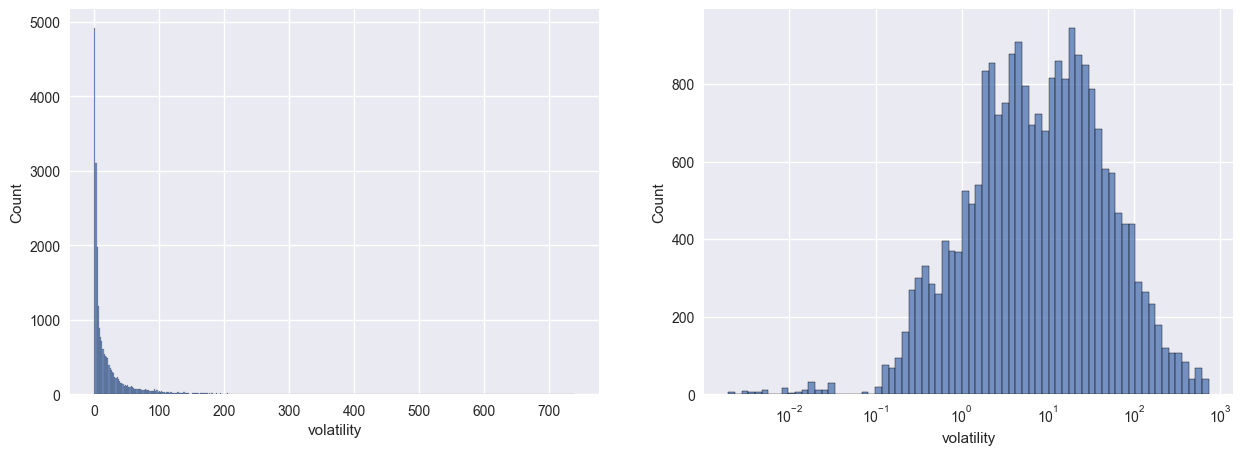

In [176]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(stocks_df['volatility'], log_scale=False, ax=ax[0])
sns.histplot(stocks_df['volatility'], log_scale=True, ax=ax[1])

<Axes: xlabel='Sharpe', ylabel='Count'>

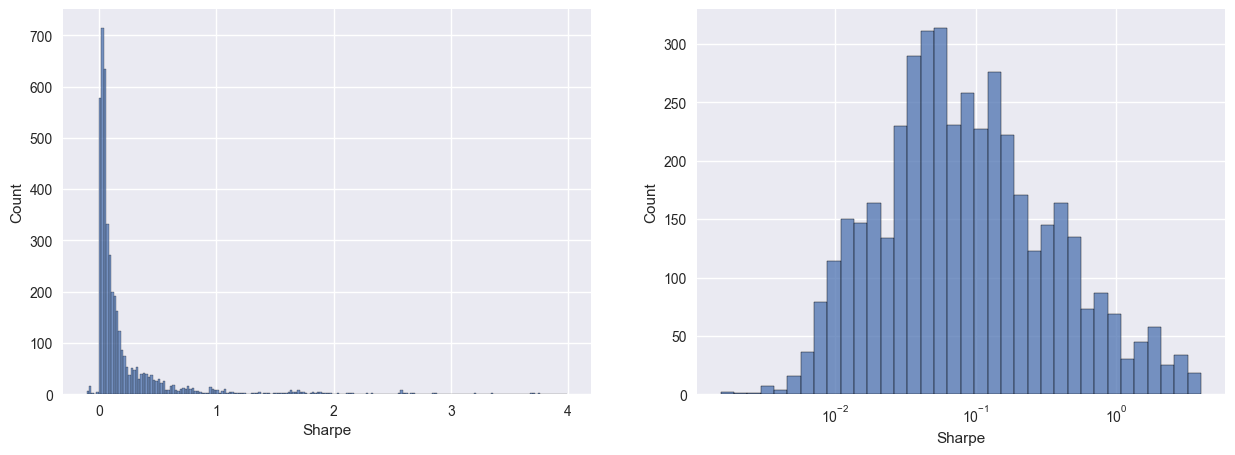

In [177]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(stocks_df['Sharpe'], log_scale=False, ax=ax[0])
sns.histplot(stocks_df['Sharpe'], log_scale=True, ax=ax[1])

In [205]:
(stocks_df['Sharpe']>0.5).value_counts()

Sharpe
False    22732
True       511
Name: count, dtype: int64

In [219]:
t_ = stocks_df[stocks_df['Sharpe']>0.5].Ticker.value_counts()
high_sharp_tickers = t_.index[t_>=10]
t_

Ticker
HLXB    82
ROMA    79
JVSA    68
LEGT    55
DYCQ    44
JL      38
IBAC    32
BKHA    23
MFI     19
MNDR    18
SYNX    13
INTJ    11
UMAC    10
YYGH     7
TWG      7
CHRO     3
MAMO     1
TRSG     1
Name: count, dtype: int64

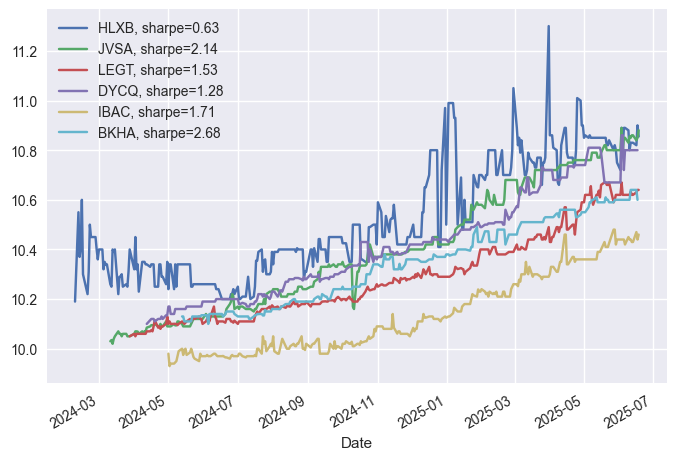

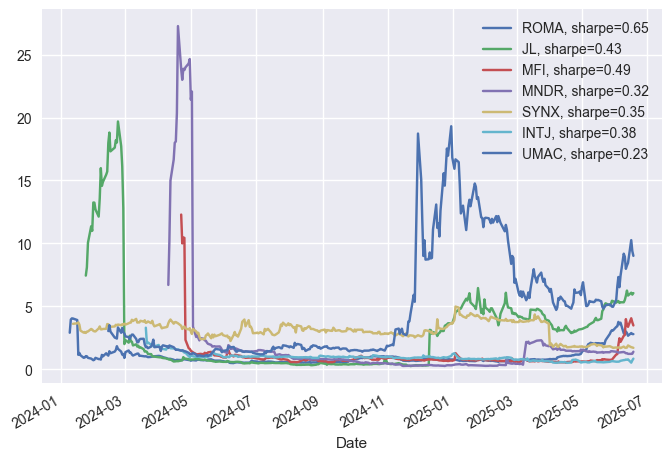

In [220]:
ax = None
for ticker in high_sharp_tickers:
    if stocks_df[stocks_df.Ticker==ticker].Close.iloc[-1]>=10:
        sharpe = stocks_df[stocks_df.Ticker==ticker].Sharpe.median()
        ax = stocks_df[stocks_df.Ticker==ticker].plot(x='Date', y='Close', label=f"{ticker}, {sharpe=:.2f}", ax=ax)
    
ax=None
for ticker in high_sharp_tickers:
    if stocks_df[stocks_df.Ticker==ticker].Close.iloc[-1]<10:
        sharpe = stocks_df[stocks_df.Ticker==ticker].Sharpe.median()
        ax = stocks_df[stocks_df.Ticker==ticker].plot(x='Date', y='Close', label=f"{ticker}, {sharpe=:.2f}", ax=ax)

4. Filter the DataFrame to keep data only for the trading day:  
   **‘2025-06-06’**

   Compute descriptive statistics (e.g., `.describe()`) for these columns:  
   - `growth_252d`  
   - `Sharpe`

   You should observe:  
   - `growth_252d` is defined for **71 out of 75 stocks** (some IPOs are too recent or data starts later).  
   - Median `growth_252d` is approximately **0.75** (indicating a 25% decline), while mean is about **1.15**, showing a bias towards high-growth companies pushing the average up.


In [251]:
stocks_250606 = stocks_df[stocks_df.Date == pd.to_datetime('2025-06-06')]
#df_.T.iloc[:,:5]

In [252]:
stocks_250606[['growth_252d', 'Sharpe']].describe()

,growth_252d,Sharpe
count,71.000000,71.000000
mean,1.152898,0.288285
std,1.406017,0.519028
min,0.024970,-0.079677
25%,0.293422,0.041215
50%,0.758065,0.083768
75%,1.362736,0.311507
max,8.097413,2.835668


In [253]:
(stocks_250606.growth_252d>1.0).value_counts()

growth_252d
False    45
True     30
Name: count, dtype: int64

In [254]:
(stocks_250606.growth_252d>1.15).value_counts()

growth_252d
False    55
True     20
Name: count, dtype: int64

<Axes: xlabel='growth_252d', ylabel='Count'>

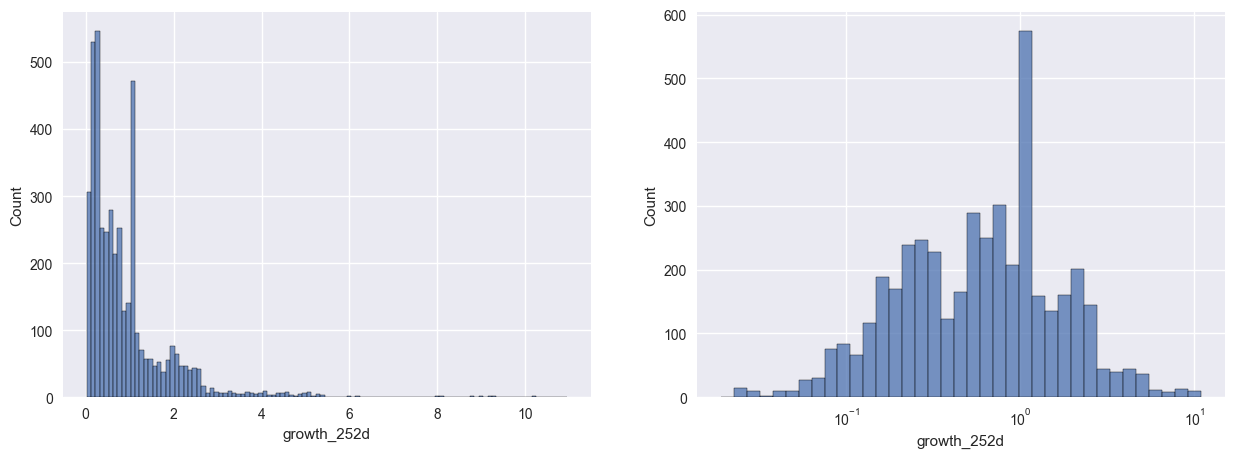

In [230]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(stocks_df['growth_252d'], log_scale=False, ax=ax[0])
sns.histplot(stocks_df['growth_252d'], log_scale=True, ax=ax[1])

<Axes: xlabel='growth_252d', ylabel='Count'>

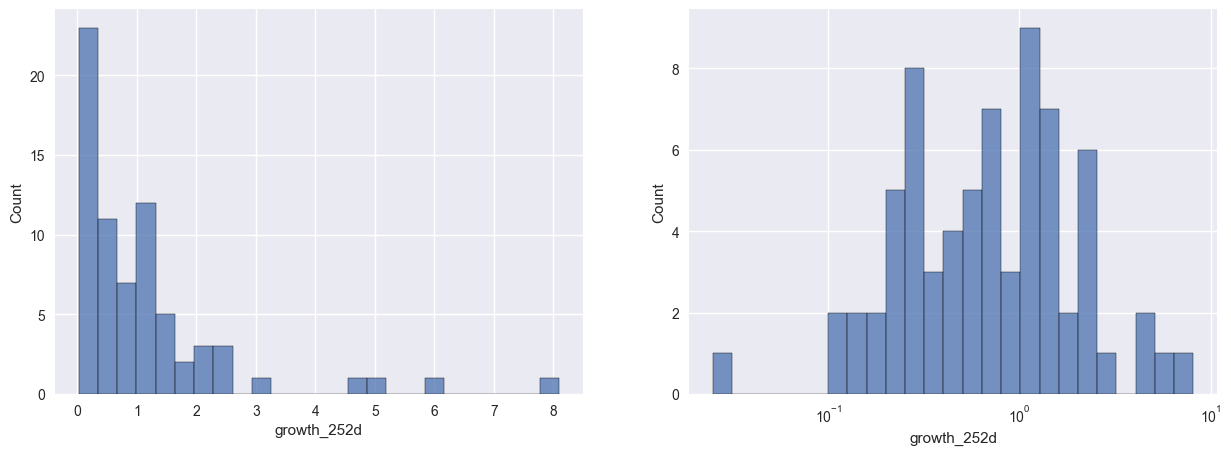

In [255]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(stocks_250606['growth_252d'], bins=25, log_scale=False, ax=ax[0])
sns.histplot(stocks_250606['growth_252d'], bins=25, log_scale=True, ax=ax[1])

In [256]:
t_ = stocks_250606[stocks_250606['growth_252d']>1].Ticker.values
#tickers = t_.index
t_

array(['BOW', 'HDL', 'ZK', 'NNE', 'VIK', 'ZONE', 'LOAR', 'MRX', 'RBRK',
       'MFI', 'YYGH', 'MTEN', 'ULS', 'MNDR', 'IBAC', 'BKHA', 'RDDT',
       'ALAB', 'DYCQ', 'UMAC', 'HLXB', 'TBBB', 'AHR', 'LEGT', 'AS',
       'AVBP', 'BTSG', 'JL', 'JVSA', 'ROMA'], dtype=object)

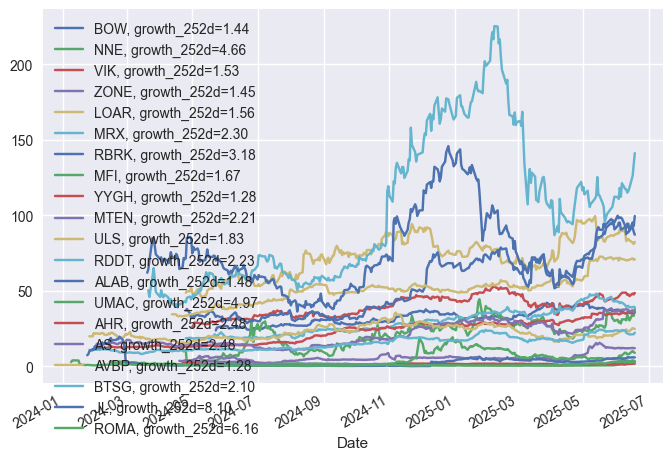

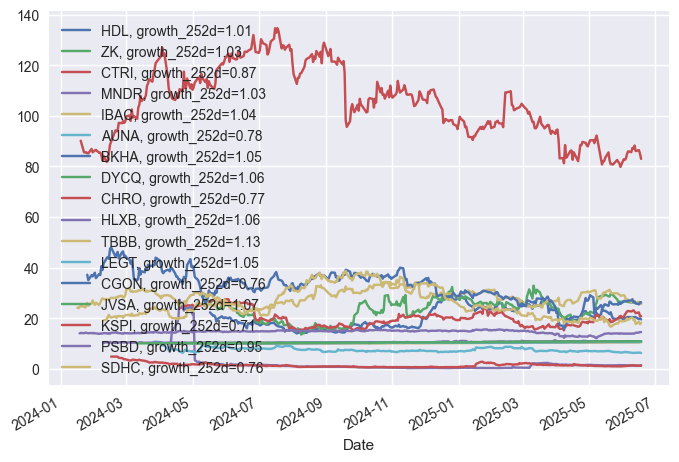

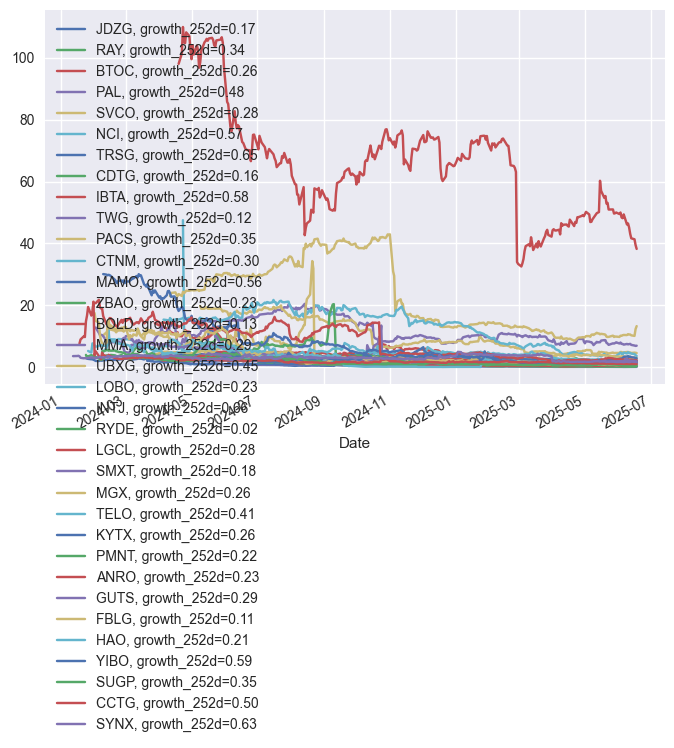

In [258]:
tickers = stocks_250606[stocks_250606['growth_252d']>1.15].Ticker.values
ax = None
for ticker in tickers:
    growth_252d = stocks_250606[stocks_250606.Ticker==ticker].growth_252d.values[0]
    ax = stocks_df[stocks_df.Ticker==ticker].plot(x='Date', y='Close', label=f"{ticker}, {growth_252d=:.2f}", ax=ax)

tickers = stocks_250606[(stocks_250606['growth_252d']>0.7) & (stocks_250606['growth_252d']<1.15)].Ticker.values
ax = None
for ticker in tickers:
    growth_252d = stocks_250606[stocks_250606.Ticker==ticker].growth_252d.values[0]
    ax = stocks_df[stocks_df.Ticker==ticker].plot(x='Date', y='Close', label=f"{ticker}, {growth_252d=:.2f}", ax=ax)

tickers = stocks_250606[(stocks_250606['growth_252d']<0.7)].Ticker.values
ax = None
for ticker in tickers:
    growth_252d = stocks_250606[stocks_250606.Ticker==ticker].growth_252d.values[0]
    ax = stocks_df[stocks_df.Ticker==ticker].plot(x='Date', y='Close', label=f"{ticker}, {growth_252d=:.2f}", ax=ax)

5. **Answer:**  
   - What is the **median Sharpe ratio** for these 71 stocks?  
   - Note: Positive `Sharpe` means growth exceeding the risk-free rate of 4.5%.  
   - [Additional] Do you observe the **same top 10 companies** when sorting by `growth_252d` versus sorting by `Sharpe`?

In [259]:
stocks_250606[['growth_252d', 'Sharpe']].describe()

,growth_252d,Sharpe
count,71.000000,71.000000
mean,1.152898,0.288285
std,1.406017,0.519028
min,0.024970,-0.079677
25%,0.293422,0.041215
50%,0.758065,0.083768
75%,1.362736,0.311507
max,8.097413,2.835668


In [273]:
print(f"Median Sharpe Ratio for 71 companies as of 2025-06-06: {stocks_250606['Sharpe'].median():.2f}")

Median Sharpe Ratio for 71 companies as of 2025-06-06: 0.08


In [267]:
t_ = stocks_250606.sort_values('growth_252d', ascending=False)[['Ticker', 'growth_252d', 'Sharpe']].head(10)
top10_growth_tickers = t_.Ticker.values
t_

,Ticker,growth_252d,Sharpe
20416,JL,8.097413,0.566222
23234,ROMA,6.156406,0.486840
14240,UMAC,4.966533,0.421306
2947,NNE,4.655224,0.080707
4631,RBRK,3.184065,0.019051
16623,AHR,2.483097,0.112576
17966,AS,2.478203,0.028026
4343,MRX,2.300384,0.076540
11477,RDDT,2.225505,0.019543
6963,MTEN,2.210432,0.053200


In [269]:
t_ = stocks_250606.sort_values('Sharpe', ascending=False)[['Ticker', 'growth_252d', 'Sharpe']].head(10)
top10_sharpe_tickers = t_.Ticker.values
t_

,Ticker,growth_252d,Sharpe
10855,BKHA,1.045881,2.835668
21088,JVSA,1.071076,2.041531
16930,LEGT,1.049407,1.940267
10268,IBAC,1.044611,1.637119
14580,HLXB,1.061404,1.123493
8151,MNDR,1.030769,0.974234
13569,DYCQ,1.059863,0.969321
12103,INTJ,0.661386,0.744512
20416,JL,8.097413,0.566222
5795,TRSG,0.646209,0.518080


In [271]:
top10_growth_tickers, top10_sharpe_tickers

(array(['JL', 'ROMA', 'UMAC', 'NNE', 'RBRK', 'AHR', 'AS', 'MRX', 'RDDT',
        'MTEN'], dtype=object),
 array(['BKHA', 'JVSA', 'LEGT', 'IBAC', 'HLXB', 'MNDR', 'DYCQ', 'INTJ',
        'JL', 'TRSG'], dtype=object))

In [272]:
np.intersect1d(top10_growth_tickers, top10_sharpe_tickers)

array(['JL'], dtype=object)

##### Question 2. What is the median Sharpe ratio (as of 6 June 2025) for companies that went public in the first 5 months of 2024? (4 points)

* ~~0.03~~
* ~~0.14~~
* **0.08**
* ~~0.20~~



### Question 3: [IPO] ‘Fixed Months Holding Strategy’

**What is the optimal number of months (1 to 12) to hold a newly IPO'd stock in order to maximize average growth?**  
(*Assume you buy at the close of the first trading day and sell after a fixed number of trading days.*)


---

#### Goal:
Investigate whether holding an IPO stock for a fixed number of months after its first trading day produces better returns, using future growth columns.

---

#### Steps:

1. **Start from the existing DataFrame** from Question 2 (75 tickers from IPOs in the first 5 months of 2024).  

   Add **12 new columns**:  
   `future_growth_1m`, `future_growth_2m`, ..., `future_growth_12m`  
   *(Assume 1 month = 21 trading days, so growth is calculated over 21, 42, ..., 252 trading days)*  
   This logic is similar to `historyPrices['growth_future_30d']` from **Code Snippet 7**, but extended to longer timeframes.

2. **Determine the first trading day** (`min_date`) for each ticker.  
   This is the earliest date in the data for each stock.

3. **Join the data**:  
   Perform an **inner join** between the `min_date` DataFrame and the future growth data on both `ticker` and `date`.  
   ➤ You should end up with **75 records** (one per IPO) with all 12 `future_growth_...` fields populated.

4. **Compute descriptive statistics** for the resulting DataFrame:  
   Use `.describe()` or similar to analyze each of the 12 columns:  
   - `future_growth_1m`  
   - `future_growth_2m`  
   - ...  
   - `future_growth_12m`  

5. **Determine the best holding period**:  
   - Find the number of months **(1 to 12)** where the **average (mean)** future growth is **maximal**.  
   - This optimal month shows an uplift of **>1%** compared to all others.  
   - Still, the average return remains **less than 1** (i.e., expected return is less than doubling your investment).



##### Question 3. What is the optimal number of months (1 to 12) to hold a newly IPO'd stock in order to maximize average growth? (3 points)

* ~~10~~
* ~~7~~
* ~~4~~
* **2**

1. **Start from the existing DataFrame** from Question 2 (75 tickers from IPOs in the first 5 months of 2024).  

   Add **12 new columns**:  
   `future_growth_1m`, `future_growth_2m`, ..., `future_growth_12m`  
   *(Assume 1 month = 21 trading days, so growth is calculated over 21, 42, ..., 252 trading days)*  
   This logic is similar to `historyPrices['growth_future_30d']` from **Code Snippet 7**, but extended to longer timeframes.

In [275]:
stocks_df.head().T

,0,1,2,3,4
Open,23.0,24.26,25.85,26.440001,27.209999
High,24.27,26.15,26.879999,26.49,27.209999
Low,22.139999,23.98,25.075001,25.500999,25.5
Close,23.799999,25.700001,26.48,26.290001,26.139999
Volume,3335800,990500,555100,302700,200900
Dividends,0.0,0.0,0.0,0.0,0.0
Stock Splits,0.0,0.0,0.0,0.0,0.0
Ticker,BOW,BOW,BOW,BOW,BOW
Year,2024,2024,2024,2024,2024
Month,5,5,5,5,5


In [310]:
future_tfs_dict = {i+1:(i+1)*21 for i in range(12)}
print(future_tfs_dict)

{1: 21, 2: 42, 3: 63, 4: 84, 5: 105, 6: 126, 7: 147, 8: 168, 9: 189, 10: 210, 11: 231, 12: 252}


In [382]:
for i in future_tfs_dict.keys():
    stocks_df[f'growth_future_{i}m'] = stocks_df['Close'].shift(-future_tfs_dict[i]) / stocks_df['Close']

In [386]:
stocks_df[['Ticker','Date','Close']].shift(-future_tfs_dict[i])

,Ticker,Date,Close
0,BOW,2025-05-28,36.500000
1,BOW,2025-05-29,37.160000
2,BOW,2025-05-30,37.299999
3,BOW,2025-06-02,37.610001
4,BOW,2025-06-03,37.450001
...,...,...,...
23238,None,NaT,NaN
23239,None,NaT,NaN
23240,None,NaT,NaN
23241,None,NaT,NaN


In [425]:
stocks_df.head().T.tail(21)

,0,1,2,3,4
growth_365d,NaN,NaN,NaN,NaN,NaN
growth_future_30d,1.092017,0.998054,1.001133,0.987828,1.03749
growth_future_1m,1.02479,0.938132,0.955816,0.963865,0.960214
growth_future_2m,1.139076,1.088327,1.052492,1.058958,1.072303
growth_future_3m,1.301681,1.196498,1.155589,1.149106,1.198164
growth_future_4m,1.167647,1.090661,1.048338,1.053252,1.071538
growth_future_5m,1.239076,1.148249,1.111027,1.139977,1.149579
growth_future_6m,1.461765,1.392996,1.361783,1.378851,1.383321
growth_future_7m,1.443698,1.354086,1.327039,1.311525,1.321729
growth_future_8m,1.357983,1.280934,1.233761,1.248764,1.236802


2. **Determine the first trading day** (`min_date`) for each ticker.  
   This is the earliest date in the data for each stock.

In [426]:
min_date = stocks_df.groupby('Ticker')['Date'].agg('first')
min_date

Ticker
AHR    2024-02-07
ALAB   2024-03-20
ANRO   2024-02-02
AS     2024-02-01
AUNA   2024-03-22
          ...    
YIBO   2024-01-25
YYGH   2024-04-22
ZBAO   2024-04-02
ZK     2024-05-10
ZONE   2024-04-26
Name: Date, Length: 75, dtype: datetime64[ns]

In [427]:
(stocks_df.groupby('Ticker')['Date'].agg('first') == stocks_df.groupby('Ticker')['Date'].agg('min')).all()

True

<Axes: xlabel='Date', ylabel='Count'>

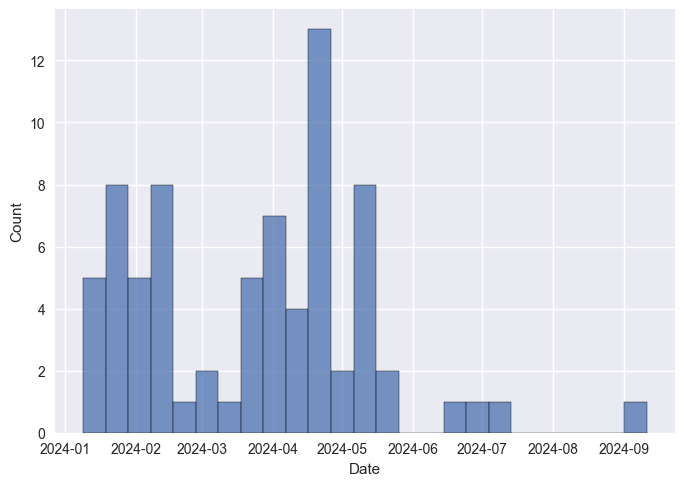

In [428]:
sns.histplot(min_date, bins=25)

3. **Join the data**:  
   Perform an **inner join** between the `min_date` DataFrame and the future growth data on both `ticker` and `date`.  
   ➤ You should end up with **75 records** (one per IPO) with all 12 `future_growth_...` fields populated.

In [429]:
growth_cols = [f"growth_future_{i+1}m" for i in range(12)]
print(growth_cols)

['growth_future_1m', 'growth_future_2m', 'growth_future_3m', 'growth_future_4m', 'growth_future_5m', 'growth_future_6m', 'growth_future_7m', 'growth_future_8m', 'growth_future_9m', 'growth_future_10m', 'growth_future_11m', 'growth_future_12m']


In [430]:
# Convert min_date Series to DataFrame and reset index
min_dates_df = min_date.reset_index()
min_dates_df.columns = ['Ticker', 'Date']

# Merge with stocks_df
first_day_df = pd.merge(
    min_dates_df,
    stocks_df[['Date', 'Ticker']+growth_cols],
    on=['Ticker', 'Date'],
    how='inner'
)

# Verify we have 75 records
print(f"Number of IPOs: {len(first_day_df)}")

# Check future growth columns are populated
future_cols = [col for col in first_day_df.columns if 'growth_future' in col]
print("\nMissing values in future growth columns:")
print(first_day_df[future_cols].isnull().sum())

Number of IPOs: 75

Missing values in future growth columns:
growth_future_1m     0
growth_future_2m     0
growth_future_3m     0
growth_future_4m     0
growth_future_5m     0
growth_future_6m     0
growth_future_7m     0
growth_future_8m     0
growth_future_9m     0
growth_future_10m    1
growth_future_11m    1
growth_future_12m    4
dtype: int64


In [431]:
print(stocks_df[future_cols].isnull().sum())

growth_future_1m      1575
growth_future_2m      3150
growth_future_3m      4725
growth_future_4m      6300
growth_future_5m      7875
growth_future_6m      9450
growth_future_7m     11025
growth_future_8m     12600
growth_future_9m     14175
growth_future_10m    15733
growth_future_11m    17287
growth_future_12m    18815
dtype: int64


4. **Compute descriptive statistics** for the resulting DataFrame:  
   Use `.describe()` or similar to analyze each of the 12 columns:  
   - `future_growth_1m`  
   - `future_growth_2m`  
   - ...  
   - `future_growth_12m`  

In [432]:
first_day_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,75,2024-03-24 07:40:48,2024-01-09 00:00:00,2024-02-08 12:00:00,2024-03-28 00:00:00,2024-04-25 00:00:00,2024-09-11 00:00:00,NaN
growth_future_1m,75.0,0.927259,0.098947,0.778984,0.977,1.046509,2.646505,0.346261
growth_future_2m,75.0,0.940544,0.0738,0.685815,1.0,1.154013,4.874759,0.574545
growth_future_3m,75.0,0.833824,0.060947,0.511212,0.9275,1.069085,2.04,0.409763
growth_future_4m,75.0,0.825086,0.045368,0.517233,0.909091,1.1343,1.605,0.401969
growth_future_5m,75.0,0.803768,0.054109,0.448403,0.821092,1.016381,3.213873,0.488348
growth_future_6m,75.0,0.864185,0.061432,0.38456,0.802239,1.093948,3.67052,0.653179
growth_future_7m,75.0,0.847149,0.044086,0.29687,0.844875,1.114468,5.12235,0.712943
growth_future_8m,75.0,0.832983,0.043103,0.208677,0.812109,1.082433,5.171484,0.762423
growth_future_9m,75.0,0.881779,0.033144,0.22674,0.822715,1.049719,6.764933,0.936957


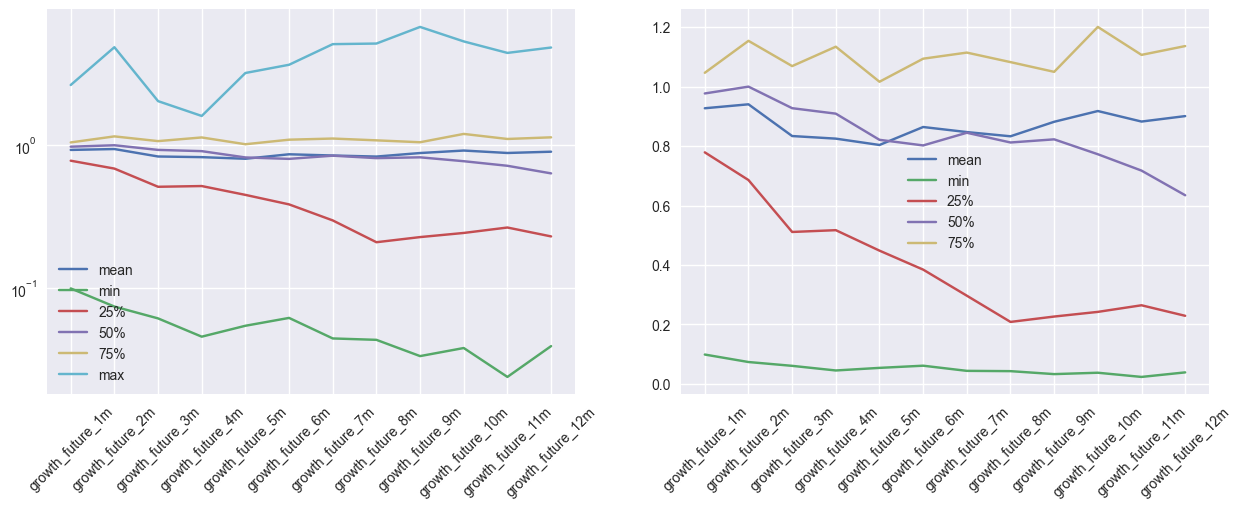

In [434]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

first_day_df.describe().iloc[1:-1, 1:].T.plot(ax=ax[0], logy=True)
ax[0].set_xticks(range(len(growth_cols)), growth_cols, rotation=45);

first_day_df.describe().iloc[1:-2, 1:].T.plot(ax=ax[1])
ax[1].set_xticks(range(len(growth_cols)), growth_cols, rotation=45);

5. **Determine the best holding period**:  
   - Find the number of months **(1 to 12)** where the **average (mean)** future growth is **maximal**.  
   - This optimal month shows an uplift of **>1%** compared to all others.  
   - Still, the average return remains **less than 1** (i.e., expected return is less than doubling your investment).

In [458]:
first_day_df.describe().T['mean'].iloc[1:]

growth_future_1m     0.927259
growth_future_2m     0.940544
growth_future_3m     0.833824
growth_future_4m     0.825086
growth_future_5m     0.803768
growth_future_6m     0.864185
growth_future_7m     0.847149
growth_future_8m     0.832983
growth_future_9m     0.881779
growth_future_10m    0.917945
growth_future_11m    0.882534
growth_future_12m    0.900861
Name: mean, dtype: object

In [459]:
-(1-first_day_df.describe().T['mean'].iloc[1:]/ \
  first_day_df.describe().T['mean'].iloc[1:].max()).apply(lambda x: round(x,3)*100)

growth_future_1m     -1.4
growth_future_2m     -0.0
growth_future_3m    -11.3
growth_future_4m    -12.3
growth_future_5m    -14.5
growth_future_6m     -8.1
growth_future_7m     -9.9
growth_future_8m    -11.4
growth_future_9m     -6.2
growth_future_10m    -2.4
growth_future_11m    -6.2
growth_future_12m    -4.2
Name: mean, dtype: float64

##### Question 3. What is the optimal number of months (1 to 12) to hold a newly IPO'd stock in order to maximize average growth? (3 points)

* ~~10~~
* ~~7~~
* ~~4~~
* **2**

### Question 4: [Strategy] Simple RSI-Based Trading Strategy


**What is the total profit (in **\$** thousands) you would have earned by investing **\$** 1000 every time a stock was oversold (RSI < 25)?**


---

#### Goal:
Apply a simple rule-based trading strategy using the **Relative Strength Index (RSI)** technical indicator to identify oversold signals and calculate profits.

---


#### Steps:

1. **Run the full notebook from Lecture 2 (33 stocks)**  
   - Ensure you can generate the merged DataFrame containing:  
     - OHLCV data  
     - Technical indicators  
     - Macro indicators  
   - Focus on getting **RSI** computed using **Code Snippets 8 and 9**.  
   - This process is essential and will help during the capstone project.

2. ⚠️ **IMPORTANT** Please use this file to solve the Home Assignment (**all next steps**)
 
   Download precomputed data using this snippet:

   ```python
   import gdown
   import pandas as pd

   file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
   gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
   df = pd.read_parquet("data.parquet", engine="pyarrow")

3. **RSI Strategy Setup:**  
   - RSI is already available in the dataset as a field.  
   - The threshold for **oversold** is defined as `RSI < 25`.

4. **Filter the dataset by RSI and date:**  
   ```python
   rsi_threshold = 25
   selected_df = df[
       (df['rsi'] < rsi_threshold) &
       (df['Date'] >= '2000-01-01') &
       (df['Date'] <= '2025-06-01')
   ]
5. **Calculate Net Profit Over 25 Years:**  
   - Total number of trades: **1568**  
   - For each trade, you invest **$1000**  
   - Use the 30-day forward return (`growth_future_30d`) to compute net earnings:  
     ```python
     net_income = 1000 * (selected_df['growth_future_30d'] - 1).sum()
     ```

   - **Final Answer:**  
     What is the **net income in $K** (i.e., in thousands of dollars) that could be earned using this RSI-based oversold strategy from 2000–2025?

##### Question 4. What is the total profit (in **\$** thousands) you would have earned by investing **\$** 1000 every time a stock was oversold (RSI < 25)? (3 points)

* **24**
* ~~30~~
* ~~15~~
* ~~42~~

1. **Run the full notebook from Lecture 2 (33 stocks)**  
   - Ensure you can generate the merged DataFrame containing:  
     - OHLCV data  
     - Technical indicators  
     - Macro indicators  
   - Focus on getting **RSI** computed using **Code Snippets 8 and 9**.  
   - This process is essential and will help during the capstone project.

2. ⚠️ **IMPORTANT** Please use this file to solve the Home Assignment (**all next steps**)
 
   Download precomputed data using this snippet:

   ```python
   import gdown
   import pandas as pd

   file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
   gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
   df = pd.read_parquet("data.parquet", engine="pyarrow")


In [461]:
import gdown
import pandas as pd

file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
df = pd.read_parquet("data.parquet", engine="pyarrow")

Downloading...
From (original): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-
From (redirected): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-&confirm=t&uuid=ca409b5d-1d83-4558-9b7f-c8b3b9599045
To: c:\Users\Gleb\work\courses\2025-05-30_stocks-analytics-course\stock-markets-analytics-zoomcamp-homework\homework-2\data.parquet
100%|███████████████████████████████████████████████████████████████████████████████| 130M/130M [00:21<00:00, 6.09MB/s]


In [462]:
df

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
0,0.054277,0.062259,0.054277,0.059598,1.031789e+09,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.059598,0.062791,0.059598,0.061726,3.081600e+08,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.061726,0.063323,0.061726,0.062791,1.331712e+08,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.062791,0.063323,0.060662,0.061194,6.776640e+07,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.061194,0.061726,0.059598,0.060130,4.789440e+07,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5686,3615.800049,3672.500000,3608.399902,3648.699951,1.678934e+06,0.0,0.0,LT.NS,2025,2025-05-01,...,NaN,NaN,NaN,NaN,1.003714,1.020064,1.036306,1.156301,1.233323,1.597248
5687,3648.699951,3665.000000,3603.000000,3640.000000,2.013954e+06,0.0,0.0,LT.NS,2025,2025-05-01,...,0.993181,0.989654,0.781299,0.842957,0.995927,1.011165,1.020634,1.162549,1.292217,1.570651
5688,3660.000000,3663.000000,3620.000000,3646.300049,1.293244e+06,0.0,0.0,LT.NS,2025,2025-05-01,...,0.992203,1.000308,0.798376,0.886128,0.989061,0.988691,0.982898,1.135015,1.272691,1.578452
5689,3663.899902,3668.899902,3618.000000,3655.300049,1.972248e+06,0.0,0.0,LT.NS,2025,2025-05-01,...,0.978792,0.991959,0.794034,0.863857,0.979958,0.965291,0.945990,1.120454,1.252080,1.563254


In [471]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229932 entries, 0 to 5690
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 301.7+ MB


In [488]:
df.dtypes.value_counts()

float64           129
int32              64
int64               5
datetime64[ns]      3
object              2
Name: count, dtype: int64

In [509]:
#df.describe().T

<Axes: >

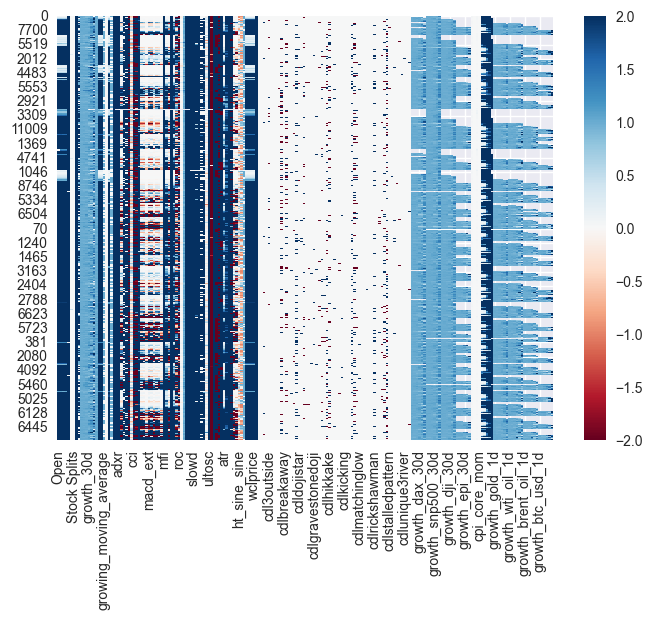

In [506]:
sns.heatmap(df.select_dtypes(include=np.number).iloc[::100],
    cmap='RdBu',
    center=0,
    vmin=-2,
    vmax=2
)

<Axes: >

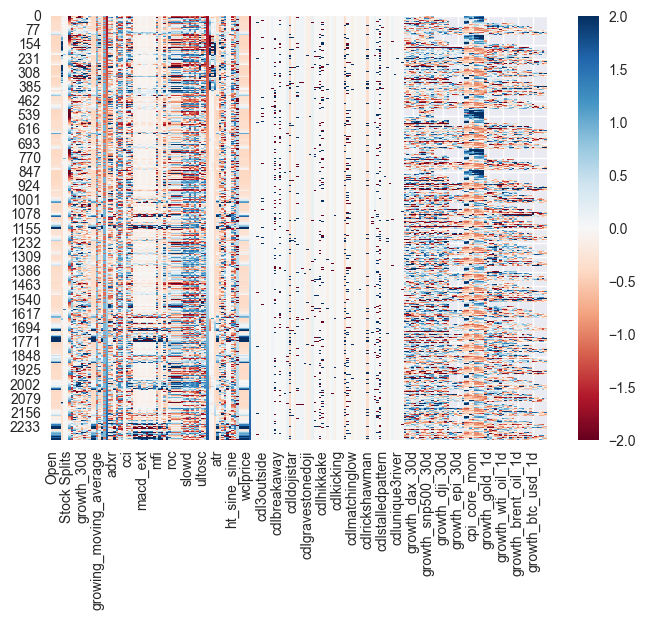

In [503]:
from sklearn.preprocessing import StandardScaler

numeric_df = df.select_dtypes(include=np.number).iloc[::100]

scaler = StandardScaler()
normalized_df = pd.DataFrame(
    scaler.fit_transform(numeric_df),
    columns=numeric_df.columns
)

sns.heatmap(
    normalized_df,
    cmap='RdBu',
    center=0,
    vmin=-2,
    vmax=2
)

<Axes: >

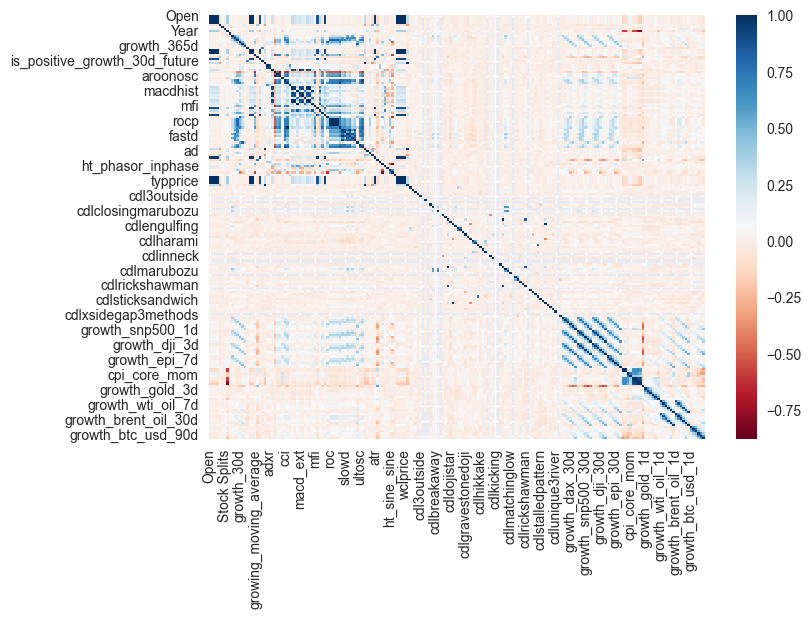

In [512]:
sns.heatmap(normalized_df.corr(), cmap='RdBu')

C:\Users\Gleb\miniconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\Gleb\miniconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


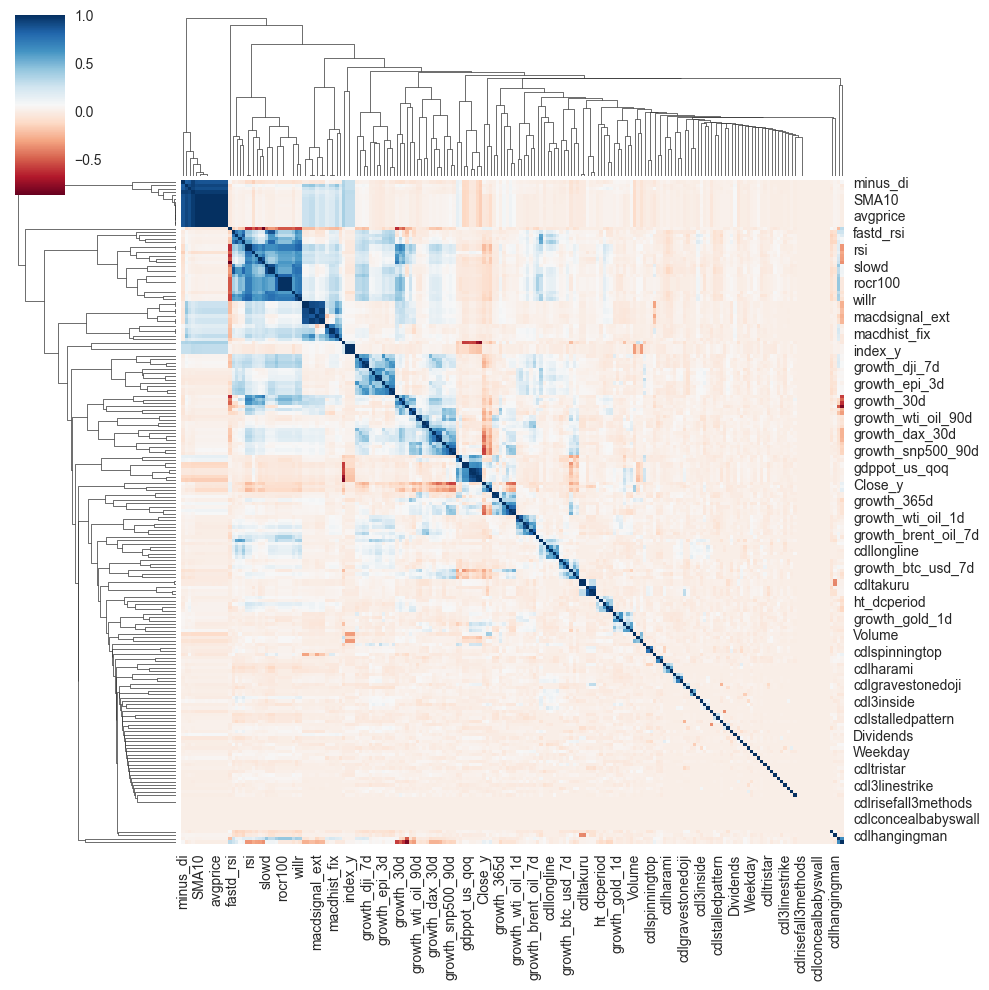

In [514]:
sns.clustermap(    
    normalized_df.corr().fillna(0),
    cmap='RdBu',
)

In [517]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap
import seaborn as sns
import matplotlib.pyplot as plt

# K-means
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(normalized_df.fillna(0))

# t-SNE
tsne = TSNE(random_state=42)
tsne_data = tsne.fit_transform(normalized_df.fillna(0))


(-56.51144561767578, 58.03958282470703, -63.42490425109863, 58.14393653869629)

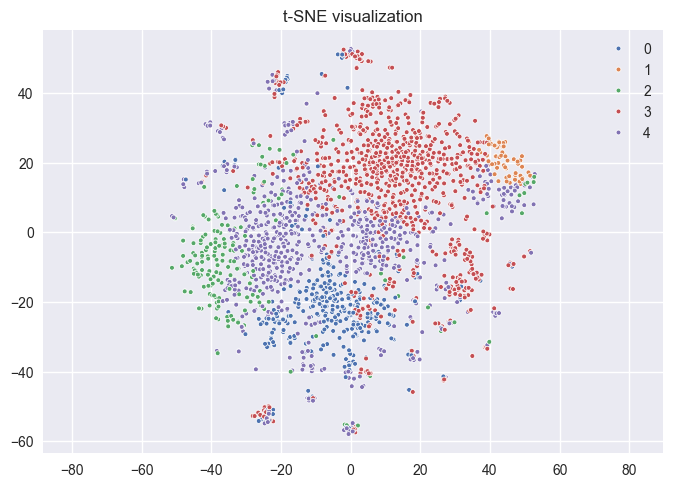

In [547]:
# t-SNE plot
sns.scatterplot(
    x=tsne_data[:, 0],
    y=tsne_data[:, 1],
    marker='.',
    hue=clusters,
    palette='deep',
)
plt.title('t-SNE visualization')
plt.axis('equal')

In [522]:
# UMAP
reducer = umap.UMAP(random_state=42)
umap_data = reducer.fit_transform(normalized_df.fillna(0))

C:\Users\Gleb\miniconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5.0, 15.0)

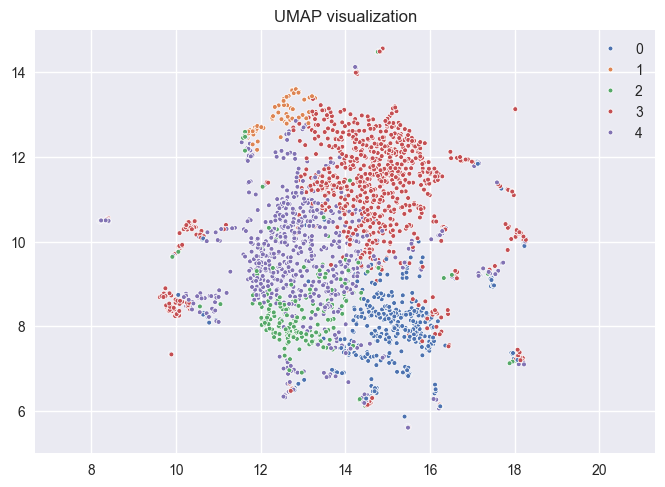

In [548]:
# UMAP plot
sns.scatterplot(
    x=umap_data[:, 0],
    y=umap_data[:, 1],
    marker='.',
    hue=clusters,
    palette='deep',
)
plt.title('UMAP visualization')
plt.axis('equal')

plt.xlim(9, 19)
plt.ylim(5, 15)

In [468]:
print(df.head().columns.values)

['Open' 'High' 'Low' 'Close_x' 'Volume' 'Dividends' 'Stock Splits'
 'Ticker' 'Year' 'Month' 'Weekday' 'Date' 'growth_1d' 'growth_3d'
 'growth_7d' 'growth_30d' 'growth_90d' 'growth_365d' 'growth_future_30d'
 'SMA10' 'SMA20' 'growing_moving_average' 'high_minus_low_relative'
 'volatility' 'is_positive_growth_30d_future' 'ticker_type' 'index_x'
 'adx' 'adxr' 'apo' 'aroon_1' 'aroon_2' 'aroonosc' 'bop' 'cci' 'cmo' 'dx'
 'macd' 'macdsignal' 'macdhist' 'macd_ext' 'macdsignal_ext' 'macdhist_ext'
 'macd_fix' 'macdsignal_fix' 'macdhist_fix' 'mfi' 'minus_di' 'mom'
 'plus_di' 'dm' 'ppo' 'roc' 'rocp' 'rocr' 'rocr100' 'rsi' 'slowk' 'slowd'
 'fastk' 'fastd' 'fastk_rsi' 'fastd_rsi' 'trix' 'ultosc' 'willr' 'index_y'
 'ad' 'adosc' 'obv' 'atr' 'natr' 'ht_dcperiod' 'ht_dcphase'
 'ht_phasor_inphase' 'ht_phasor_quadrature' 'ht_sine_sine'
 'ht_sine_leadsine' 'ht_trendmod' 'avgprice' 'medprice' 'typprice'
 'wclprice' 'index' 'cdl2crows' 'cdl3blackrows' 'cdl3inside'
 'cdl3linestrike' 'cdl3outside' 'cdl3starsin

3. **RSI Strategy Setup:**  
   - RSI is already available in the dataset as a field.  
   - The threshold for **oversold** is defined as `RSI < 25`.


In [531]:
df.columns[df.columns.str.lower().str.contains('rsi')]

Index(['rsi', 'fastk_rsi', 'fastd_rsi', 'cdl3starsinsouth'], dtype='object')

In [538]:
df.Ticker.value_counts()[:10]

Ticker
LLY              13361
JPM              11395
AAPL             11207
NVO              11112
MSFT              9881
CDI.PA            8600
TTE               8459
ASML              7604
SAP               7475
HINDUNILVR.NS     7386
Name: count, dtype: int64

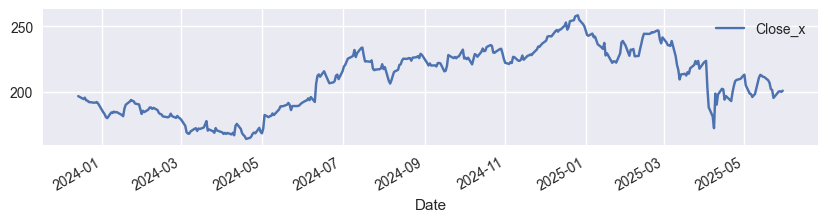

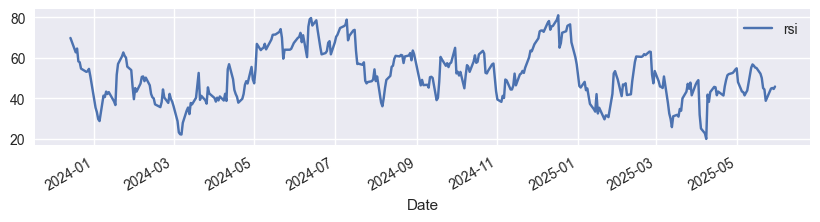

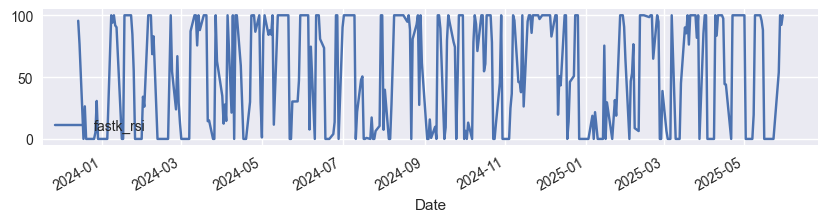

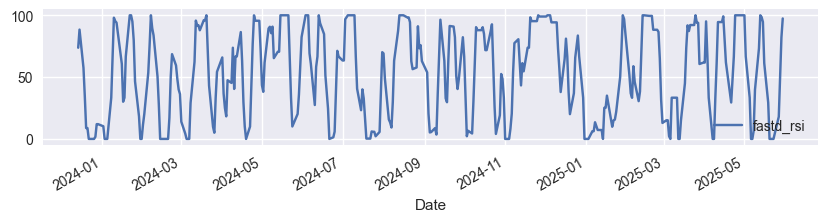

In [545]:
for col in ['Close_x', 'rsi', 'fastk_rsi', 'fastd_rsi']:
    df[df.Ticker=='AAPL'].iloc[-365:].plot(x='Date', y=col, figsize=(10,2))

In [570]:
np.corrcoef(df['rsi'].fillna(0) ,df['growth_1d'].fillna(0))[0,1]

0.28155832322050844

In [571]:
np.corrcoef(df['rsi'].fillna(0) ,df['growth_30d'].fillna(0))[0,1]

0.6814154853219524

In [572]:
np.corrcoef(df['rsi'].fillna(0) ,df['growth_future_30d'].fillna(0))[0,1]

-0.02578141227475639

In [573]:
np.corrcoef(selected_df['rsi'].fillna(0) ,selected_df['growth_future_30d'].fillna(0))[0,1]

-0.18865510358011733

In [574]:
np.corrcoef(selected_df['rsi'].fillna(0) ,selected_df['growth_30d'].fillna(0))[0,1]

0.031261213770849804

In [585]:
corr_df = df.corrwith(df['growth_future_30d'], numeric_only=True)

corr_df = pd.DataFrame(corr_df, columns=['corr'])
corr_df['abs'] = corr_df['corr'].abs()
corr_df.sort_values('abs', ascending=False)[:20]

C:\Users\Gleb\miniconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Gleb\miniconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,corr,abs
growth_future_30d,1.000000,1.000000
is_positive_growth_30d_future,0.665060,0.665060
growth_7d,-0.048524,0.048524
growth_3d,-0.048006,0.048006
natr,0.042862,0.042862
growth_brent_oil_365d,-0.039987,0.039987
roc,-0.037400,0.037400
rocp,-0.037400,0.037400
rocr100,-0.037400,0.037400
rocr,-0.037400,0.037400


4. **Filter the dataset by RSI and date:**  
   ```python
   rsi_threshold = 25
   selected_df = df[
       (df['rsi'] < rsi_threshold) &
       (df['Date'] >= '2000-01-01') &
       (df['Date'] <= '2025-06-01')
   ]

In [546]:
rsi_threshold = 25
selected_df = df[
    (df['rsi'] < rsi_threshold) &
    (df['Date'] >= '2000-01-01') &
    (df['Date'] <= '2025-06-01')
]

In [562]:
selected_df.Ticker.value_counts()[:10]

Ticker
LT.NS            96
RMS.PA           92
IBN              85
TCS.NS           80
SIE.DE           78
INFY             76
SBIN.NS          75
CDI.PA           70
HINDUNILVR.NS    62
NVDA             60
Name: count, dtype: int64

In [586]:
corr_df = selected_df.corrwith(selected_df['growth_future_30d'], numeric_only=True)

corr_df = pd.DataFrame(corr_df, columns=['corr'])
corr_df['abs'] = corr_df['corr'].abs()
corr_df.sort_values('abs', ascending=False)[:20]

C:\Users\Gleb\miniconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Gleb\miniconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,corr,abs
growth_future_30d,1.000000,1.000000
return,1.000000,1.000000
is_positive_growth_30d_future,0.467837,0.467837
growth_btc_usd_3d,0.270770,0.270770
adxr,0.239020,0.239020
growth_btc_usd_1d,0.222006,0.222006
willr,0.217682,0.217682
adx,0.206436,0.206436
growth_btc_usd_7d,0.197369,0.197369
aroon_2,0.194617,0.194617


5. **Calculate Net Profit Over 25 Years:**  
   - Total number of trades: **1568**  
   - For each trade, you invest **$1000**  
   - Use the 30-day forward return (`growth_future_30d`) to compute net earnings:  
     ```python
     net_income = 1000 * (selected_df['growth_future_30d'] - 1).sum()
     ```

In [549]:
selected_df.shape

(1568, 203)

In [550]:
selected_df['return'] = 1000 * (selected_df['growth_future_30d'] - 1)

C:\Users\Gleb\AppData\Local\Temp\ipykernel_14036\1750390521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['return'] = 1000 * (selected_df['growth_future_30d'] - 1)


<Axes: xlabel='Date'>

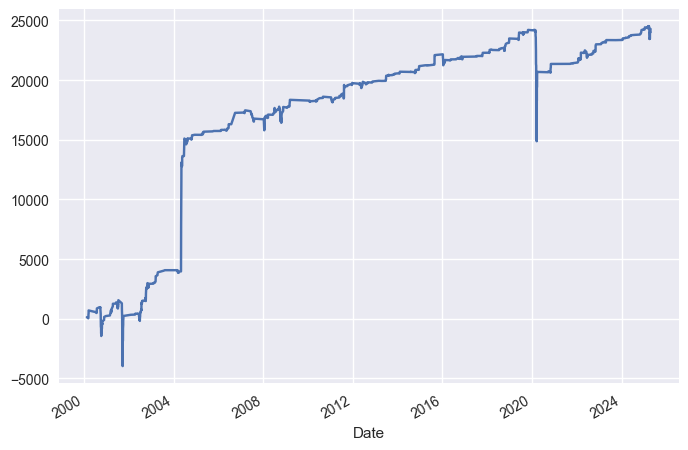

In [559]:
selected_df.sort_values('Date').set_index('Date')['return'].cumsum().plot()

#selected_df.sort_values('Date').set_index('Date')['growth_1d'].apply(lambda x: (x)*1000).cumsum().plot()

In [560]:
net_income = 1000 * (selected_df['growth_future_30d'] - 1).sum()
net_income

24295.523125248386

   - **Final Answer:**  
     What is the **net income in $K** (i.e., in thousands of dollars) that could be earned using this RSI-based oversold strategy from 2000–2025?

##### Question 4. What is the total profit (in **\$** thousands) you would have earned by investing **\$** 1000 every time a stock was oversold (RSI < 25)? (3 points)

* **24**
* ~~30~~
* ~~15~~
* ~~42~~

### Q5. [Exploratory, Optional] Predicting a Positive-Return IPO

Most of the strategies for investing in IPOs deliver **negative average and median returns** (and even 75% quantiles).

**Question:**  
How would you change the strategy if you want to **increase the profitability**?

> This is an open-ended brainstorming question — propose ideas for identifying IPOs with positive future returns or building a more effective trading strategy.

##### ***Answer:*** Potential IPO strategy improvements:

1. Company Classification Analysis:
   - Use company categorization (as in question 1)
   - Focus on classes with better historical returns

   
2. Optimal Entry Timing:
   - Wait 2 months after IPO (as shown in question 3)
   - Use technical indicators (RSI < 25) for entry

   
3. Metric Filtering:
   - IPO size (filter out very small ones)
   - First-day trading volatility assessment
   - Trading volume analysis


4. Risk Management:
   - Sector diversification
   - Position size limits
   - Stop-losses at 15-20%


5. Additional Factors:
   - Underwriter analysis (financial institutions, investment banks, that manage the IPO)
   - Market condition assessment
   - Lock-up period consideration

## Submitting the solutions

Form for submitting: https://courses.datatalks.club/sma-zoomcamp-2025/homework/hw02


## Leaderboard

Leaderboard link: https://courses.datatalks.club/sma-zoomcamp-2025/leaderboard